# 펭귄 몸무게 예측 경진대회 
### 참가자 : wbpark

코드제출했던 파일(256.9점) 복원에 실패했습니다.  
작업 중간중간에 분석 잘 되고 있는지 파일 저장하면서 작업했고,   
코드 수정 중에 중간저장 했던 파일 제출한 게 최고점이네요. 
일일 제출수 초과로 이전 설정값 찾는건 실패한 것 같아요!  

일단 분석 방법 공유하고, 최대한 비슷하게 픽한 데이터 공유합니다.    
아마, 아래 결과 파일 중 점수가 비슷한 게 없다면 15_N, 13_C 열을 제거하고 학습 돌렸던 데이터거나     
cluster에 원핫 인코딩 걸기 전에 pca(n=2)로 적용 했던 데이터였을 수 있을 것 같아요.   
pca 분석과 관련해서는 cluter마다 서로 다른 예측모델을 각각 만들어서 해당 cluster별로 따로 학습을 시키고 했던 것 같은데.. 코드도 길고 효과도 없고, 시각화 했을 때 별로 예쁘지도 않고 해서 그냥 걷어내고 저장했는데..   
아니면 진짜 전처리 과정에서 test Data가 섞여 들어간 체로 학습되어 점수가 높아진 것일 수도 있을 것 같습니다.   

스스로 보기에도 부정행위와 구분 불가능한 상태인 것 같아서..  
원칙적으로 실격/기권하는 게 맞아보이네요 ㅠㅠ

현제 제출한 코드에서 출력되는 파일 중에 그나마 점수 비슷한걸 적용하시거나,   
검증 심사하시다가 **애매하다 싶으면 기권 처리**하셔도 될 것 같습니다!  

암튼 대회 중 공부한 내용 공유드립니다! 

1. train.csv : 학습 데이터

    - id : 샘플 아이디
    - Species: 펭귄의 종을 나타내는 문자열
    - Island : 샘플들이 수집된 Palmer Station 근처 섬 이름
    - Clutch Completion : 관찰된 펭귄 둥지의 알이 2개인 경우 Full Clutch이며 Yes로 표기
    - Culmen Length (mm) : 펭귄 옆모습 기준 부리의 가로 길이
    - Culmen Depth (mm) : 펭귄 옆모습 기준 부리의 세로 길이
    - Flipper Length (mm) : 펭귄의 팔(날개) 길이
    - Sex : 펭귄의 성별
    - Delta 15 N (o/oo)  : 토양에 따라 변화하는 안정 동위원소 15N:14N의 비율
    - Delta 13 C (o/oo) : 먹이에 따라 변화하는 안정 동위원소 13C:12C의 비율
    - Body Mass (g): 펭귄의 몸무게를 나타내는 숫자 (g)


2. test.csv : 테스트 데이터
    - train.csv 스키마에서 에서 Body Mass (g) 제외

3. sample_submissoin.csv : 제출 양식
    - id : 샘플 아이디
    - Body Mass (g) : 펭귄의 몸무게를 나타내는 숫자 (g)

[데이터 상세 설명](https://allisonhorst.github.io/palmerpenguins/)  
    성인 Adélie, Chinstrap 및 Gentoo 펭귄의 둥지 관찰, 펭귄 크기 데이터 및 혈액 샘플의 동위원소 측정을 포함한 데이터입니다. 남극의 Palmer Station 근처 Palmer 군도에 있는 섬에서 관찰된 Adélie, chinstrap, Gentoo 펭귄의 먹이를 찾는 성체의 크기 측정, 클러치 관찰 및 혈액 동위원소 비율. 데이터는 Kristen Gor man 박사와 Palmer Station Long Term Ecological Research(LTER) 프로그램에 의해 수집되어 제공되었습니다.

# 1 Read DataSet
## 1.1. Pretreatment
- 1.1.1. 데이터를 읽습니다.
- 1.1.2. 종의 이름을 짧게 수정합니다.
- 1.1.3. 편의를 위해 컬럼명을 짧게 수정합니다.
- 1.1.4. 범주형 변수의 타입을 카테고리로 명시합니다
- 1.1.5. 처리한 데이터의 내용을 확인합니다

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1.1.1. Read Data 
train_data = pd.read_csv('../data/train.csv').sort_values(by='id',ascending=True)
test_data = pd.read_csv('../data/test.csv').sort_values(by='id',ascending=True)
print("train 데이터 크기 : %s 행 %s 열" % train_data.shape)
print("test  데이터 크기 : %s 행 %s 열" % test_data.shape)

# 1.1.2. Species Data 짧게 변경
train_data["Species"] = train_data["Species"].apply(lambda x : x.split()[0])
test_data["Species"] = test_data["Species"].apply(lambda x : x.split()[0])

# 1.1.3. 열이름 변경
col_rename = { 
"Clutch Completion":"Clutch",
"Culmen Length (mm)":"C_Len",
"Culmen Depth (mm)":"C_Dep",
"Flipper Length (mm)":"F_Len",
"Delta 15 N (o/oo)":"15_N",
"Delta 13 C (o/oo)":"13_C",
}
train_data.rename(columns = col_rename, inplace=True)
test_data.rename(columns = col_rename, inplace=True)

# 1.1.4. 열 카테고리화
cols_categorical = ["Species","Island","Clutch","Sex"]
for colName in cols_categorical:
    train_data[colName] = train_data[colName].astype('category')
    test_data[colName] = test_data[colName].astype('category')

# 1.1.5. Data 예시출력
display( train_data.head(2) )
display( train_data.tail(2) )
display( test_data.head(2) )
display( test_data.tail(2) )

train 데이터 크기 : 114 행 11 열
test  데이터 크기 : 228 행 10 열


,id,Species,Island,Clutch,C_Len,C_Dep,F_Len,Sex,15_N,13_C,Body Mass (g)
0,0,Gentoo,Biscoe,Yes,50.0,15.3,220,MALE,8.30515,-25.19017,5550
1,1,Chinstrap,Dream,No,49.5,19.0,200,MALE,9.63074,-24.34684,3800


,id,Species,Island,Clutch,C_Len,C_Dep,F_Len,Sex,15_N,13_C,Body Mass (g)
112,112,Chinstrap,Dream,No,46.9,16.6,192,FEMALE,9.80589,-24.73735,2700
113,113,Gentoo,Biscoe,Yes,50.8,17.3,228,MALE,8.27428,-26.30019,5600


,id,Species,Island,Clutch,C_Len,C_Dep,F_Len,Sex,15_N,13_C
0,0,Chinstrap,Dream,Yes,52.0,20.7,210.0,MALE,9.43146,-24.68440
1,1,Gentoo,Biscoe,Yes,55.9,17.0,228.0,MALE,8.31180,-26.35425


,id,Species,Island,Clutch,C_Len,C_Dep,F_Len,Sex,15_N,13_C
226,226,Chinstrap,Dream,Yes,50.5,19.6,201.0,MALE,9.8059,-24.72940
227,227,Adelie,Biscoe,Yes,37.6,19.1,194.0,MALE,9.1080,-25.89677


## 1.2. Check Categorical Field
- 1.2.1. categoric 필드와 numeric 필드를 구분합니다
- 1.2.2. categoric 필드에 속한 값을 확인합니다.

In [2]:
# 1.2.1. categoric 필드와 numeric 필드를 구분합니다
cols_categorical = ["Species","Island","Clutch","Sex"]
cols_numerical = list(filter(lambda x : not x in ['id',*cols_categorical],list(train_data.columns)))
print(f"numerical\t: {cols_numerical}")
print(f"categorical\t: {cols_categorical}")

# 1.2.2. categoric 필드에 속한 값을 확인합니다.
print("\nCheck categories")
for col in cols_categorical: 
    print(col, list(train_data[col].cat.categories), sep="\t: ")

numerical	: ['C_Len', 'C_Dep', 'F_Len', '15_N', '13_C', 'Body Mass (g)']
categorical	: ['Species', 'Island', 'Clutch', 'Sex']

Check categories
Species	: ['Adelie', 'Chinstrap', 'Gentoo']
Island	: ['Biscoe', 'Dream', 'Torgersen']
Clutch	: ['No', 'Yes']
Sex	: ['FEMALE', 'MALE']


## 1.3. Check Null
- 1.3.1. 결측값 개수 확인

In [3]:
# 1.3.1. 결측값 개수 확인
print("결측값 개수 확인")
display(train_data.isnull().sum().loc[lambda x : x>0]) # 항목별 결측값 수
display(test_data.isnull().sum().loc[lambda x : x>0]) # 항목별 결측값 수

결측값 개수 확인


Sex     3
15_N    3
13_C    3
dtype: int64

Sex     6
15_N    9
13_C    8
dtype: int64

# 2 Visualize Data 
## 2.1. Significant group classification
- 2.1.1. box plot (Species, Sex)에 따른 몸무게 데이터 분포 확인  
= > Species & Sex 집단마다 몸무게 분포에 유의미한 차이를 확인할 수 있다.  
- 2.1.2. box plot (Species, island)에 따른 몸무게 데이터 분포 확인  
=> Island에 따른 몸무게 편차는 거의 없다.  
=> Chinstrap, Gentoo 펭귄은 한 섬에서만 산다.
- 2.1.3. swarm plot (Species, Clutch, island)에 따른 몸무게 데이터 분포 확인  
=> Clutch의 경우 No 데이터이 수가 매우 적어 학습 데이터로 활용할 가치가 적어보인다.  
=> Gentoo, Chinstrape 펭귄의 경우 1개의 Island에 서식한다.  
=> Adelie 펭귄의 경우 Island에 따른 몸무게 편차가 적어보인다.   
=> 따라서 Island도 학습 데이터로 활용하는 것이 무의미해보인다.
- 2.1.4. box plot (Species, island)에 따른 13_C, 15_N 데이터 분포 확인  
=> 학습에 Island 필드를 제외하더라도 13_C, 15_N 필드에 의해 해당 집단별 특징이 유지될 수 있을 것이다.

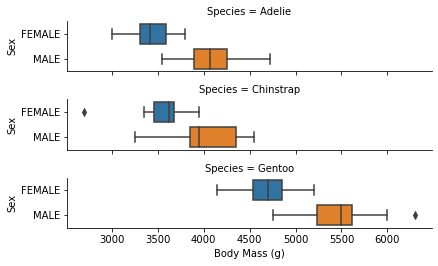

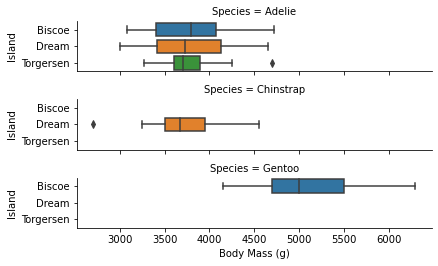

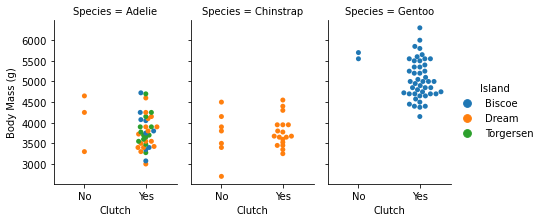

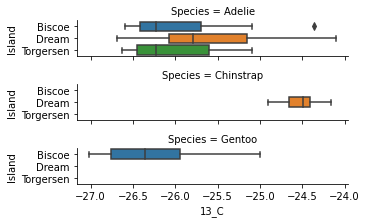

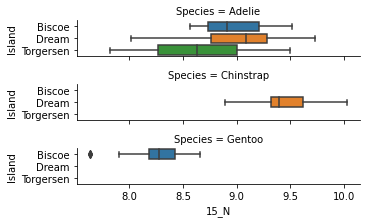

In [4]:
# 2.1.1. box plot (Species, Sex)에 따른 몸무게 데이터 분포 확인  
sns.catplot(x="Body Mass (g)", y="Sex", row="Species", 
            orient="h", height=1.2, aspect=5, 
            kind="box", data=train_data)


# 2.1.2 box plot (Species, island)에 따른 몸무게 데이터 분포 확인  
sns.catplot(x="Body Mass (g)", y="Island", row="Species", 
            orient="h", height=1.2, aspect=5, 
            kind="box", data=train_data)

# 2.1.3 swarm plot (Species, Clutch, island)에 따른 몸무게 데이터 분포 확인 
sns.catplot(x="Clutch", y="Body Mass (g)", col="Species",
            hue="Island", height=3, aspect=0.7, 
            kind="swarm", data=train_data)

# 2.1.4 box plot (Species, island)에 따른 13_C, 15_N 데이터 분포 확인  
sns.catplot(x="13_C", y="Island", row="Species", 
            orient="h", height=1, aspect=5, 
            kind="box", data=train_data)
sns.catplot(x="15_N", y="Island", row="Species", 
            orient="h", height=1, aspect=5, 
            kind="box", data=train_data)

## 2.2. Set Cluster
-  2.2.1. 전처리 함수 정의
-  2.2.2. 전처리 함수 적용
-  2.2.3. 분석 및 학습에 사용될 변수만 남김
-  2.2.4. 분석 및 학습에 사용될 데이터 확인
  
### 2.2. 방법 및 의도
- (Species, Sex, Island, Clutch) 등 범주형 데이터를 열 하나(Cluster)으로 분류합니다.
- 이는 원핫 인코딩의 대상이 될 범주형 데이터를 최소화 하기 위함입니다.
- 해당 과정을 거치지 않고 원핫 인코딩을 할 경우, Sex에 따른 coeff가 서로 다른 Species에서도 일괄적으로 적용될 수 있습니다.
- Biscoe, Gentoo펭귄은 하나의 섬에서만 관측되었기 때문에 Island 필드가 의미를 갖지 못합니다.
- Adelie펭귄의 몸무게는 섬에 따른 특징이 보이지 않습니다.
- Island 필드를 사용할 경우, Dream, Biscoe 섬에 사는 다른 종의 펭귄 데이터에 의해 영향을 받을 수 있으므로 Island 데이터는 무시합니다.
- Island에 의한 편차는 13_C와 15_N에 간접적으로 남아있습니다.

In [5]:
# 2.2.1. 전처리 함수 정의
def Prepare_Data(df):
    df.at[ (df["Species"]=="Gentoo")   & (df["Sex"]=="FEMALE") ,"Cluster"] = "Gentoo_F"
    df.at[ (df["Species"]=="Gentoo")   & (df["Sex"]=="MALE")   ,"Cluster"] = "Gentoo_M"
    df.at[ (df["Species"]=="Chinstrap")& (df["Sex"]=="FEMALE") ,"Cluster"] = "Chinstrap_F"
    df.at[ (df["Species"]=="Chinstrap")& (df["Sex"]=="MALE")   ,"Cluster"] = "Chinstrap_M"
    df.at[ (df["Species"]=="Adelie")   & (df["Sex"]=="FEMALE") ,"Cluster"] = "Adelie_F"
    df.at[ (df["Species"]=="Adelie")   & (df["Sex"]=="MALE")   ,"Cluster"] = "Adelie_M"
    df['Cluster'] = df['Cluster'].astype('category')
    return df.sort_values(by='Cluster',ascending=False)

# 2.2.2. 전처리 함수 적용
train_data = Prepare_Data(train_data)
test_data = Prepare_Data(test_data)

# 2.2.3. 분석 및 학습에 사용될 변수만 남김
cols = ["id","Cluster","F_Len","C_Len","C_Dep","15_N","13_C"]
train_X = train_data.loc[:,cols]
train_y = train_data.loc[:,["id","Cluster","Body Mass (g)"]]
test_X  = test_data.loc[:,cols]

# 2.2.4. 분석 및 학습에 사용될 데이터 확인
display(train_X.head(1))
display(train_y.head(1))
display(test_X.head(1))

,id,Cluster,F_Len,C_Len,C_Dep,15_N,13_C
0,0,Gentoo_M,220,50.0,15.3,8.30515,-25.19017


,id,Cluster,Body Mass (g)
0,0,Gentoo_M,5550


,id,Cluster,F_Len,C_Len,C_Dep,15_N,13_C
114,114,Gentoo_M,220.0,48.5,14.1,8.39867,-26.79358


## 2.3. Visualize correlation
- pair plot으로 변수간 상관관계를 파악한다. 
- (Species, Sex)로 나누 Cluster마다 색갈을 따로 칠해 집단간 분포를 확인한다.

Cluster | Species | Sex
:--:|:--:|:--:
0 | Gentoo | FEMALE
1 | Gentoo | MALE
2 | Chinstrap | FEMALE
3 | Chinstrap | MALE
4 | Adelie | FEMALE
5 | Adelie | MALE


### 2.3. 결론
- 해당 cluster가 모든 영역에서 서로 구분되도록 분포하고 있다. (그룹별 추세선의 차이가 크다)
- pairplot의 대각선 라인을 보면 각 집단별로 data가 정규분포와 유사하게 분포되어 있음을 확인할 수 있다.

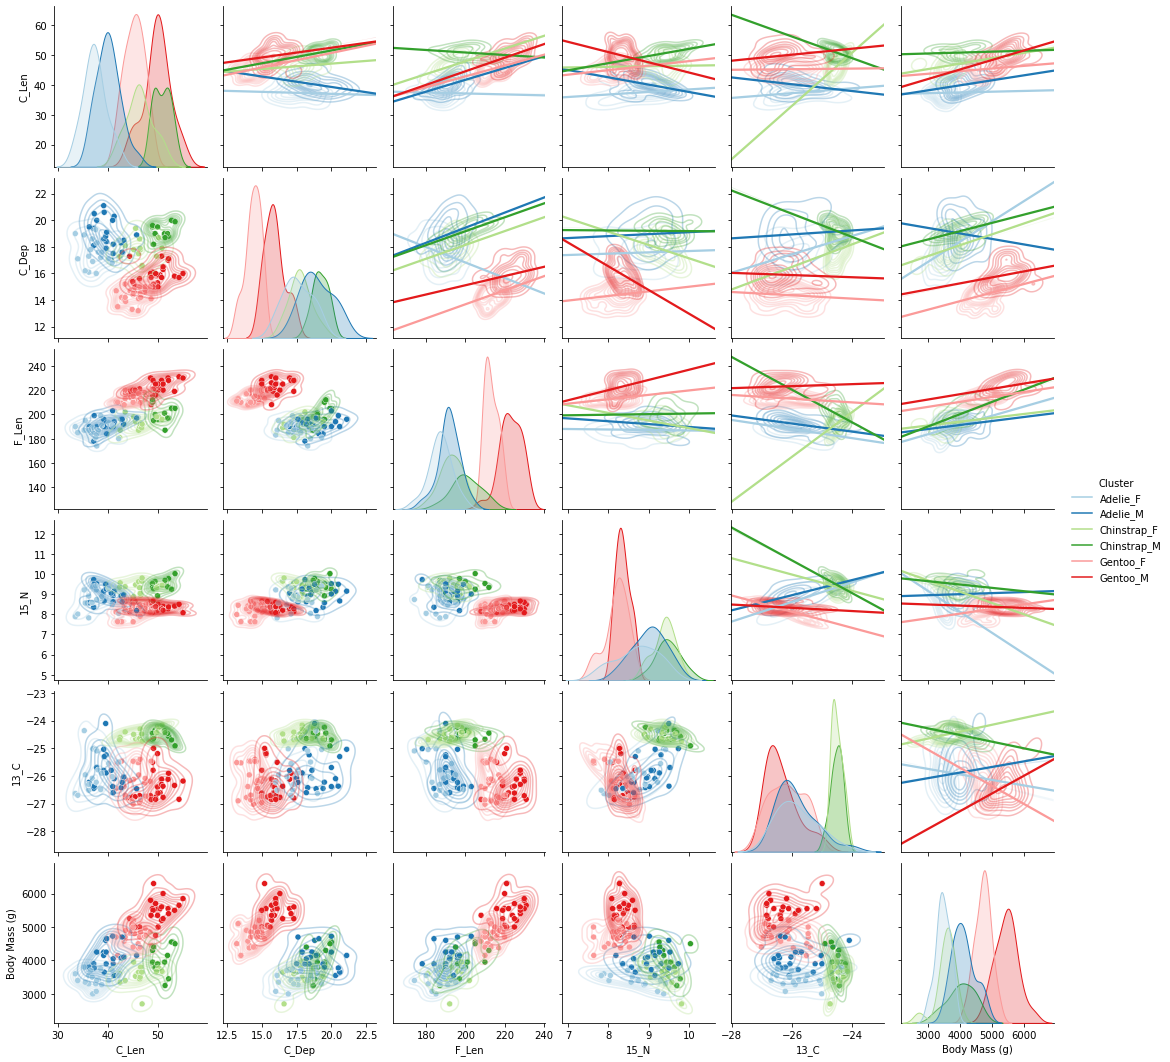

In [6]:
hue_Data = "Cluster"
g = sns.pairplot(train_data[[*cols_numerical,hue_Data]], hue=hue_Data, 
                 kind="kde", plot_kws={"alpha":0.3}, palette="Paired")
g.map_lower(sns.scatterplot)
g.map_upper(sns.regplot, scatter=False, truncate=False, ci=True)    
display(g)

# 3. Fill Null (Sex,15_N, 13_C)

## 3.1. Set 결측값 처리 
성별에 따른 분포가 정규분포 모양 잘 구분되어 있어 GaussianNB를 사용해 Sex를 예측합니다
- 3.1.1 Sex 결측값 예측 모델 생성
- 3.1.2 Sex 결측값 예측 모델 학습
- 3.1.3. train data Sex 결측값 체우기 
- 3.1.4. test data Sex 결측값 체우기
- 3.1.5. Cluster 생성 (2.2.1 참조)   

In [7]:
train_data = train_data.sort_values(by='id',ascending=True)
test_data = test_data.sort_values(by='id',ascending=True)

# 결측값 존재했던 idx 저장 
idx_nan_tran = train_data.isnull().sum(axis=1).apply(lambda x : x>0)
idx_nan_test = test_data.isnull().sum(axis=1).apply(lambda x : x>0)

display(train_data.loc[idx_nan_tran]) # 결측값 1개라도 포함
display(test_data.loc[idx_nan_test]) # 결측값 1개라도 포함

,id,Species,Island,Clutch,C_Len,C_Dep,F_Len,Sex,15_N,13_C,Body Mass (g),Cluster
6,6,Adelie,Torgersen,Yes,42.0,20.2,190,NaN,9.13362,-25.09368,4250,NaN
8,8,Adelie,Torgersen,Yes,34.1,18.1,193,NaN,NaN,NaN,3475,NaN
18,18,Adelie,Dream,No,39.8,19.1,184,MALE,NaN,NaN,4650,Adelie_M
70,70,Gentoo,Biscoe,Yes,46.2,14.4,214,NaN,8.24253,-26.81540,4650,NaN
109,109,Adelie,Torgersen,Yes,36.6,17.8,185,FEMALE,NaN,NaN,3700,Adelie_F


,id,Species,Island,Clutch,C_Len,C_Dep,F_Len,Sex,15_N,13_C,Cluster
27,27,Adelie,Torgersen,Yes,38.6,21.2,191.0,MALE,NaN,NaN,Adelie_M
46,46,Adelie,Torgersen,Yes,37.8,17.1,186.0,NaN,8.63243,-25.21315,NaN
75,75,Chinstrap,Dream,Yes,51.9,19.5,206.0,MALE,NaN,-23.78767,Chinstrap_M
81,81,Adelie,Dream,Yes,37.5,18.9,179.0,NaN,NaN,NaN,NaN
98,98,Gentoo,Biscoe,Yes,47.3,13.8,216.0,NaN,8.25818,-26.23886,NaN
106,106,Gentoo,Biscoe,Yes,47.3,15.3,222.0,MALE,NaN,NaN,Gentoo_M
152,152,Gentoo,Biscoe,Yes,44.5,15.7,217.0,NaN,8.04111,-26.18444,NaN
159,159,Adelie,Torgersen,Yes,41.1,17.6,182.0,FEMALE,NaN,NaN,Adelie_F
175,175,Adelie,Dream,Yes,40.8,18.4,195.0,MALE,NaN,NaN,Adelie_M
202,202,Adelie,Torgersen,Yes,39.1,18.7,181.0,MALE,NaN,NaN,Adelie_M


In [8]:
from sklearn.naive_bayes  import GaussianNB
from sklearn.metrics      import accuracy_score

# 3.1.1 Sex 결측값 예측 모델 생성
GNB = GaussianNB()
cols = ['Species','C_Len', 'C_Dep', 'F_Len'] # Species는 One Hot Encoding

# 3.1.2 Sex 결측값 예측 모델 학습
train_Sex_Y = train_data[train_data['Sex'].notnull()]['Sex']
train_Sex_X = train_data[train_data['Sex'].notnull()][cols]
train_Sex_X = pd.get_dummies(train_Sex_X, columns= ['Species'])
GNB.fit(train_Sex_X,train_Sex_Y)
print("Sex 학습 정확도 :",accuracy_score(train_Sex_Y, GNB.predict(train_Sex_X)))

# 3.1.3. train data Sex 결측값 체우기 
idx = train_data['Sex'].isnull() ; 
train_Sex_nan = train_data[idx][cols]
train_Sex_nan = pd.get_dummies(train_Sex_nan, columns= ['Species']) # 원핫 인코딩
if train_Sex_nan.shape[0] > 0 : 
    train_data.at[train_data['Sex'].isnull(),['Sex']] = GNB.predict(train_Sex_nan)
else : print("이미 결측값 체움")
    
# 3.1.4. test data Sex 결측값 체우기
idx = test_data['Sex'].isnull()
test_Sex_nan = test_data[idx][cols]
test_Sex_nan = pd.get_dummies(test_Sex_nan, columns= ['Species'])
if test_Sex_nan.shape[0] > 0 : 
    test_data.at[test_data['Sex'].isnull(),['Sex']] = GNB.predict(test_Sex_nan)
else : print("이미 결측값 체움")

# 3.1.5. Cluster 생성 (2.2.1 참조)
train_data = Prepare_Data(train_data).sort_values(by='id',ascending=True)
test_data = Prepare_Data(test_data).sort_values(by='id',ascending=True)

Sex 학습 정확도 : 0.8558558558558559


##  3.2. 혈중 동위원소비 (15_N, 13_C) 결측값 처리 
결측값의 개수가 적어 따로 model을 학습시키는 대신 cluster별 해당 필드 평균값으로 체워넣습니다.
-  3.2.1. Cluseter별 필드 평균값 확인
-  3.2.2. Cluster 평균값으로 결측값 입력(13_C , 15_N)
-  3.2.3. 결측값 체운 데이터와 비교

In [9]:
# 3.2.1. Cluseter별 필드 평균값 확인
df_group_mean = train_data.groupby('Cluster').mean()
display(df_group_mean)

# 3.2.2. Cluster 평균값으로 결측값 입력(13_C , 15_N)
for col in ['13_C','15_N']:
    for cat in list(train_data['Cluster'].cat.categories):
        # 호출 형식 
        # # df_group_mean.loc['Adelie_F']['15_N']
        test_data.at[test_data['Cluster']==cat,col] = test_data.loc[test_data['Cluster']==cat,col].fillna(df_group_mean.loc[cat][col])
        train_data.at[train_data['Cluster']==cat,col] = train_data.loc[train_data['Cluster']==cat,col].fillna(df_group_mean.loc[cat][col])
        
# 3.2.3. 결측값 체운 데이터와 비교
display(train_data.loc[idx_nan_tran]) # 결측값 1개라도 포함
display(test_data.loc[idx_nan_test])  # 결측값 1개라도 포함

,id,C_Len,C_Dep,F_Len,15_N,13_C,Body Mass (g)
Cluster,,,,,,,
Adelie_F,54.105263,37.221053,17.600000,187.473684,8.700501,-25.832280,3450.000000
Adelie_M,50.363636,40.186364,19.022727,191.545455,9.012591,-25.822631,4104.545455
Chinstrap_F,62.071429,46.392857,17.764286,192.642857,9.370609,-24.508136,3550.000000
Chinstrap_M,48.545455,50.918182,19.200000,200.454545,9.476756,-24.525462,4018.181818
Gentoo_F,56.416667,45.350000,14.379167,213.250000,8.200750,-26.197335,4705.208333
Gentoo_M,64.500000,49.858333,15.908333,223.000000,8.352234,-26.341860,5445.833333


,id,Species,Island,Clutch,C_Len,C_Dep,F_Len,Sex,15_N,13_C,Body Mass (g),Cluster
6,6,Adelie,Torgersen,Yes,42.0,20.2,190,MALE,9.133620,-25.093680,4250,Adelie_M
8,8,Adelie,Torgersen,Yes,34.1,18.1,193,FEMALE,8.700501,-25.832280,3475,Adelie_F
18,18,Adelie,Dream,No,39.8,19.1,184,MALE,9.012591,-25.822631,4650,Adelie_M
70,70,Gentoo,Biscoe,Yes,46.2,14.4,214,FEMALE,8.242530,-26.815400,4650,Gentoo_F
109,109,Adelie,Torgersen,Yes,36.6,17.8,185,FEMALE,8.700501,-25.832280,3700,Adelie_F


,id,Species,Island,Clutch,C_Len,C_Dep,F_Len,Sex,15_N,13_C,Cluster
27,27,Adelie,Torgersen,Yes,38.6,21.2,191.0,MALE,9.012591,-25.822631,Adelie_M
46,46,Adelie,Torgersen,Yes,37.8,17.1,186.0,FEMALE,8.632430,-25.213150,Adelie_F
75,75,Chinstrap,Dream,Yes,51.9,19.5,206.0,MALE,9.476756,-23.787670,Chinstrap_M
81,81,Adelie,Dream,Yes,37.5,18.9,179.0,FEMALE,8.700501,-25.832280,Adelie_F
98,98,Gentoo,Biscoe,Yes,47.3,13.8,216.0,FEMALE,8.258180,-26.238860,Gentoo_F
106,106,Gentoo,Biscoe,Yes,47.3,15.3,222.0,MALE,8.352234,-26.341860,Gentoo_M
152,152,Gentoo,Biscoe,Yes,44.5,15.7,217.0,FEMALE,8.041110,-26.184440,Gentoo_F
159,159,Adelie,Torgersen,Yes,41.1,17.6,182.0,FEMALE,8.700501,-25.832280,Adelie_F
175,175,Adelie,Dream,Yes,40.8,18.4,195.0,MALE,9.012591,-25.822631,Adelie_M
202,202,Adelie,Torgersen,Yes,39.1,18.7,181.0,MALE,9.012591,-25.822631,Adelie_M


# 4. Machine Learning
## 4.1. set Dataset
- 4.1.1. 학습 데이터 전처리
- 4.1.2. train set 만들기
- 4.1.3 test set 만들기

In [10]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

cols = ['Cluster','C_Len', 'C_Dep', 'F_Len','15_N', '13_C']
seed = 7

# 4.1.1. 학습 데이터 전처리
X_all = pd.get_dummies(train_data[cols], columns= ['Cluster'])
y_all =train_data['Body Mass (g)']

# 4.1.2. train set 만들기
X_train, X_valid, y_train, y_valid = train_test_split(
    pd.get_dummies(train_data[['Cluster',*cols]], columns= ['Cluster']),
    train_data['Body Mass (g)'],test_size=0.2,random_state=seed)

# 4.1.3 test set 만들기
test_data = test_data.sort_values(by='id',ascending=True)
X_test = pd.get_dummies(test_data[['Cluster',*cols]], columns= ['Cluster'])

train_data.head(3)

,id,Species,Island,Clutch,C_Len,C_Dep,F_Len,Sex,15_N,13_C,Body Mass (g),Cluster
0,0,Gentoo,Biscoe,Yes,50.0,15.3,220,MALE,8.30515,-25.19017,5550,Gentoo_M
1,1,Chinstrap,Dream,No,49.5,19.0,200,MALE,9.63074,-24.34684,3800,Chinstrap_M
2,2,Gentoo,Biscoe,Yes,45.1,14.4,210,FEMALE,8.51951,-27.01854,4400,Gentoo_F


## 4.2. Find best Model
- 4.2.1. 모듈 불러오기
- 4.2.2. 몸무게 5g 단위로 예측하도록 설정
- 4.2.3. 학습결과 에러 확인

(주의) 4.2.2 설정이 학습(fit)과정에서도 적용되는 것인지,   
아니면 결과물의 표시 형식만 바꾸는 정도의 차이인지 잘 모르겠습니다.    
혹시 아시는 분 계시다면 댓글로 알려주시면 감사하겠습니다.  
사실 fit 부분을 Override 하고 싶었는데 구현부분을 몰라서 predic만 수정하였습니다.  

In [11]:
# 4.2.1. 모듈 불러오기
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# 4.2.2. 몸무게 5g 단위로 예측하도록 설정
def Scale_unit(arr,div=5):
    return np.array( [ x - x%div + ( div if x%div > div/2 else 0) for x in arr ] )

class custom_LinearRegression(LinearRegression):
    def predict(self,df): return Scale_unit(super().predict(df))

class custom_Lasso(Lasso):
    def predict(self,df): return Scale_unit(super().predict(df))
    
class custom_KNeighborsRegressor(KNeighborsRegressor):
    def predict(self,df): return Scale_unit(super().predict(df))
    
class custom_DecisionTreeRegressor(DecisionTreeRegressor):
    def predict(self,df): return Scale_unit(super().predict(df))
    
class custom_ElasticNet(ElasticNet):
    def predict(self,df): return Scale_unit(super().predict(df))
    
class custom_SVR(SVR):
    def predict(self,df): return Scale_unit(super().predict(df))

class custom_RandomForestRegressor(RandomForestRegressor):
    def predict(self,df): return Scale_unit(super().predict(df))
    
class custom_AdaBoostRegressor(AdaBoostRegressor):
    def predict(self,df): return Scale_unit(super().predict(df))
    
class custom_ExtraTreesRegressor(ExtraTreesRegressor):
    def predict(self,df): return Scale_unit(super().predict(df))
    
# 4.2.3 학습결과 에러 확인
def Show_ML_info(models,results =[],names=[]):
    scoring = 'neg_root_mean_squared_error'

    for name, model in models:
        kfold = KFold(n_splits=10,random_state=7,shuffle = True)
        cv_results = cross_val_score(model,X_train,y_train
                                   ,cv= kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s : %f (%f) "%(name,cv_results.mean(),cv_results.std())
        print(msg)
        
    return results ,names

## 4.3. Compare Models 
= > Lasso 회귀분석과 Linear 회귀분석의 결과값이 가장 좋았다.

### 4.3.1. Train with Base Data

In [12]:
models = []
results = []
names=[]

# 랜덤 seed 없는 회귀식
models.append(('LR',LinearRegression()))
models.append(('SVM',SVR()))
models.append(('KNN',KNeighborsRegressor()))

# 랜덤 seed 있는 회귀식
models.append(('LASSO',Lasso(random_state=seed)))
models.append(('CART',DecisionTreeRegressor(random_state=seed)))
models.append(('EN',ElasticNet(random_state=seed)))
models.append(('RFR',RandomForestRegressor(random_state=seed)))
models.append(('AdaR',AdaBoostRegressor(random_state=seed)))
models.append(('Xtree',ExtraTreesRegressor(random_state=seed)))

# 5g 단위로 반올림하여 적용
models.append(('ctm_LR',custom_LinearRegression()))
models.append(('ctm_SVM',custom_SVR()))
models.append(('ctm_KNN',custom_KNeighborsRegressor()))

# 5g 단위로 반올림하여 적용
models.append(('ctm_LASSO',custom_Lasso(random_state=seed)))
models.append(('ctm_CART',custom_DecisionTreeRegressor(random_state=seed)))
models.append(('ctm_EN',custom_ElasticNet(random_state=seed)))
models.append(('ctm_RFR',custom_RandomForestRegressor(random_state=seed)))
models.append(('ctm_AdaR',custom_AdaBoostRegressor(random_state=seed)))
models.append(('ctm_Xtree',custom_ExtraTreesRegressor(random_state=seed)))

results ,names = Show_ML_info(models)

LR : -319.388258 (56.881615) 
SVM : -775.645148 (193.162199) 
KNN : -387.527288 (60.741859) 
LASSO : -320.071105 (55.589445) 
CART : -459.461505 (82.094884) 
EN : -370.938929 (61.533686) 
RFR : -352.211569 (66.043581) 
AdaR : -361.354173 (52.346999) 
Xtree : -336.529862 (79.855042) 
ctm_LR : -319.476799 (56.799769) 
ctm_SVM : -776.139575 (193.273337) 
ctm_KNN : -387.527288 (60.741859) 
ctm_LASSO : -319.968137 (55.594288) 
ctm_CART : -459.461505 (82.094884) 
ctm_EN : -370.932318 (61.606448) 
ctm_RFR : -352.469363 (66.106509) 
ctm_AdaR : -361.445475 (52.548673) 
ctm_Xtree : -336.386572 (79.788901) 


### 4.3.2. Train with StandardScaled Data

In [13]:
pipelines = []

# 랜덤 seed 없는 회귀식
pipelines.append(('ScaledLR',Pipeline([('Scaler',preprocessing.StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledSVM',Pipeline([('Scaler',preprocessing.StandardScaler()),('SVM',SVR())])))
pipelines.append(('ScaledKNN',Pipeline([('Scaler',preprocessing.StandardScaler()),('KNN',KNeighborsRegressor())])))

# 랜덤 seed 있는 회귀식
pipelines.append(('ScaledLASSO',Pipeline([('Scaler',preprocessing.StandardScaler()),('LASSO',Lasso(random_state=seed))])))
pipelines.append(('ScaledCART',Pipeline([('Scaler',preprocessing.StandardScaler()),('CART',DecisionTreeRegressor(random_state=seed))])))
pipelines.append(('ScaledEN',Pipeline([('Scaler',preprocessing.StandardScaler()),('EN',ElasticNet(random_state=seed))])))
pipelines.append(('ScaledRFR',Pipeline([('Scaler',preprocessing.StandardScaler()),('RFR',RandomForestRegressor(random_state=seed))])))
pipelines.append(('ScaledAdaR',Pipeline([('Scaler',preprocessing.StandardScaler()),('AdaR',AdaBoostRegressor(random_state=seed))])))
pipelines.append(('ScaledXtree',Pipeline([('Scaler',preprocessing.StandardScaler()),('Xtree',ExtraTreesRegressor(random_state=seed))])))

# 5g 단위로 반올림하여 적용

# 랜덤 seed 없는 회귀식
pipelines.append(('ctm_ScaledLR',Pipeline([('Scaler',preprocessing.StandardScaler()),('ctm_LR',custom_LinearRegression())])))
pipelines.append(('ctm_ScaledKNN',Pipeline([('Scaler',preprocessing.StandardScaler()),('ctm_KNN',custom_KNeighborsRegressor())])))
pipelines.append(('ctm_ScaledSVM',Pipeline([('Scaler',preprocessing.StandardScaler()),('ctm_SVM',custom_SVR())])))

# 랜덤 seed 있는 회귀식
pipelines.append(('ctm_ScaledLASSO',Pipeline([('Scaler',preprocessing.StandardScaler()),('ctm_LASSO',custom_Lasso(random_state=seed))])))
pipelines.append(('ctm_ScaledCART',Pipeline([('Scaler',preprocessing.StandardScaler()),('ctm_CART',custom_DecisionTreeRegressor(random_state=seed))])))
pipelines.append(('ctm_ScaledEN',Pipeline([('Scaler',preprocessing.StandardScaler()),('ctm_EN',custom_ElasticNet(random_state=seed))])))
pipelines.append(('ctm_ScaledRFR',Pipeline([('Scaler',preprocessing.StandardScaler()),('ctm_RFR',custom_RandomForestRegressor(random_state=seed))])))
pipelines.append(('ctm_ScaledAdaR',Pipeline([('Scaler',preprocessing.StandardScaler()),('ctm_AdaR',AdaBoostRegressor(random_state=seed))])))
pipelines.append(('ctm_ScaledXtree',Pipeline([('Scaler',preprocessing.StandardScaler()),('ctm_Xtree',custom_AdaBoostRegressor(random_state=seed))])))

results_scaled ,names = Show_ML_info(models)

LR : -319.388258 (56.881615) 
SVM : -775.645148 (193.162199) 
KNN : -387.527288 (60.741859) 
LASSO : -320.071105 (55.589445) 
CART : -459.461505 (82.094884) 
EN : -370.938929 (61.533686) 
RFR : -352.211569 (66.043581) 
AdaR : -361.354173 (52.346999) 
Xtree : -336.529862 (79.855042) 
ctm_LR : -319.476799 (56.799769) 
ctm_SVM : -776.139575 (193.273337) 
ctm_KNN : -387.527288 (60.741859) 
ctm_LASSO : -319.968137 (55.594288) 
ctm_CART : -459.461505 (82.094884) 
ctm_EN : -370.932318 (61.606448) 
ctm_RFR : -352.469363 (66.106509) 
ctm_AdaR : -361.445475 (52.548673) 
ctm_Xtree : -336.386572 (79.788901) 


### 4.3.3. Train with Normalized Data

In [14]:
pipelines = []

# 랜덤 seed 없는 회귀식
pipelines.append(('NormLR',Pipeline([('Scaler',preprocessing.Normalizer()),('LR',LinearRegression())])))
pipelines.append(('NormKNN',Pipeline([('Scaler',preprocessing.Normalizer()),('KNN',KNeighborsRegressor())])))
pipelines.append(('NormSVM',Pipeline([('Scaler',preprocessing.Normalizer()),('SVM',SVR())])))

# 랜덤 seed 있는 회귀식
pipelines.append(('NormLASSO',Pipeline([('Scaler',preprocessing.Normalizer()),('LASSO',Lasso(random_state=seed))])))
pipelines.append(('NormCART',Pipeline([('Scaler',preprocessing.Normalizer()),('CART',DecisionTreeRegressor(random_state=seed))])))
pipelines.append(('NormEN',Pipeline([('Scaler',preprocessing.Normalizer()),('EN',ElasticNet(random_state=seed))])))
pipelines.append(('NormRFR',Pipeline([('Scaler',preprocessing.Normalizer()),('RFR',RandomForestRegressor(random_state=seed))])))
pipelines.append(('NormAdaR',Pipeline([('Scaler',preprocessing.Normalizer()),('AdaR',AdaBoostRegressor(random_state=seed))])))
pipelines.append(('NormXtree',Pipeline([('Scaler',preprocessing.Normalizer()),('Xtree',ExtraTreesRegressor(random_state=seed))])))

# 5g 단위로 반올림하여 적용

# 랜덤 seed 없는 회귀식
pipelines.append(('ctm_NormLR',Pipeline([('Scaler',preprocessing.Normalizer()),('ctm_LR',custom_LinearRegression())])))
pipelines.append(('ctm_NormKNN',Pipeline([('Scaler',preprocessing.Normalizer()),('ctm_KNN',custom_KNeighborsRegressor())])))
pipelines.append(('ctm_NormSVM',Pipeline([('Scaler',preprocessing.Normalizer()),('ctm_SVM',custom_SVR())])))

# 랜덤 seed 있는 회귀식
pipelines.append(('ctm_NormLASSO',Pipeline([('Scaler',preprocessing.Normalizer()),('ctm_LASSO',custom_Lasso(random_state=seed))])))
pipelines.append(('ctm_NormCART',Pipeline([('Scaler',preprocessing.Normalizer()),('ctm_CART',custom_DecisionTreeRegressor(random_state=seed))])))
pipelines.append(('ctm_NormEN',Pipeline([('Scaler',preprocessing.Normalizer()),('ctm_EN',custom_ElasticNet(random_state=seed))])))
pipelines.append(('ctm_NormRFR',Pipeline([('Scaler',preprocessing.Normalizer()),('ctm_RFR',custom_RandomForestRegressor(random_state=seed))])))
pipelines.append(('ctm_NormAdaR',Pipeline([('Scaler',preprocessing.Normalizer()),('ctm_AdaR',custom_AdaBoostRegressor(random_state=seed))])))
pipelines.append(('ctm_NormXtree',Pipeline([('Scaler',preprocessing.Normalizer()),('ctm_Xtree',custom_AdaBoostRegressor(random_state=seed))])))

results_norm ,names = Show_ML_info(models)

LR : -319.388258 (56.881615) 
SVM : -775.645148 (193.162199) 
KNN : -387.527288 (60.741859) 
LASSO : -320.071105 (55.589445) 
CART : -459.461505 (82.094884) 
EN : -370.938929 (61.533686) 
RFR : -352.211569 (66.043581) 
AdaR : -361.354173 (52.346999) 
Xtree : -336.529862 (79.855042) 
ctm_LR : -319.476799 (56.799769) 
ctm_SVM : -776.139575 (193.273337) 
ctm_KNN : -387.527288 (60.741859) 
ctm_LASSO : -319.968137 (55.594288) 
ctm_CART : -459.461505 (82.094884) 
ctm_EN : -370.932318 (61.606448) 
ctm_RFR : -352.469363 (66.106509) 
ctm_AdaR : -361.445475 (52.548673) 
ctm_Xtree : -336.386572 (79.788901) 


## 4.4. Find best Parameter

In [15]:
from sklearn.model_selection import GridSearchCV
import time
import warnings
warnings.filterwarnings('ignore')

seed = 7
num_folds = 7

cols = ['Cluster','C_Len', 'C_Dep', 'F_Len','15_N', '13_C']
# cols = ['Cluster','C_Len', 'C_Dep', 'F_Len'] # 15_N, 13_C 제외하고 학습시킬 경우 주석 해제
X_all = pd.get_dummies(train_data[cols], columns= ['Cluster'])
y_all =train_data['Body Mass (g)']

scaler = preprocessing.StandardScaler().fit(X_all)
scaled_X = scaler.transform(X_all)

scaler = preprocessing.Normalizer().fit(X_all)
Norm_X = scaler.transform(X_all)

print("\n\nBase") ; display(X_all.head(3))
print("\n\nScaled") ; display(pd.DataFrame(scaled_X, columns= list(X_all.columns)).head(3))
print("\n\nNorm") ; display(pd.DataFrame(Norm_X, columns= list(X_all.columns)).head(3))



Base


,C_Len,C_Dep,F_Len,Cluster_Adelie_F,Cluster_Adelie_M,Cluster_Chinstrap_F,Cluster_Chinstrap_M,Cluster_Gentoo_F,Cluster_Gentoo_M
0,50.0,15.3,220,0,0,0,0,0,1
1,49.5,19.0,200,0,0,0,1,0,0
2,45.1,14.4,210,0,0,0,0,1,0




Scaled


,C_Len,C_Dep,F_Len,Cluster_Adelie_F,Cluster_Adelie_M,Cluster_Chinstrap_F,Cluster_Chinstrap_M,Cluster_Gentoo_F,Cluster_Gentoo_M
0,1.016685,-0.887255,1.161653,-0.447214,-0.48901,-0.374166,-0.326797,-0.516398,1.936492
1,0.922318,1.027037,-0.209242,-0.447214,-0.48901,-0.374166,3.060006,-0.516398,-0.516398
2,0.091884,-1.352893,0.476205,-0.447214,-0.48901,-0.374166,-0.326797,1.936492,-0.516398




Norm


,C_Len,C_Dep,F_Len,Cluster_Adelie_F,Cluster_Adelie_M,Cluster_Chinstrap_F,Cluster_Chinstrap_M,Cluster_Gentoo_F,Cluster_Gentoo_M
0,0.221111,0.067660,0.972889,0.0,0.0,0.0,0.000000,0.000000,0.004422
1,0.239233,0.091827,0.966598,0.0,0.0,0.0,0.004833,0.000000,0.000000
2,0.209502,0.066892,0.975507,0.0,0.0,0.0,0.000000,0.004645,0.000000


In [16]:
# Lasso
params = {'max_iter' : range(100)}
model =Lasso(random_state = seed)

start = time.time() 
kfold = KFold(n_splits= num_folds,random_state = seed,shuffle = True)
grid = GridSearchCV(estimator= model, param_grid = params,scoring= 'neg_root_mean_squared_error',cv=kfold )
grid_result = grid.fit(X_all,y_all)

print(f"소요시간 : {time.time()  - start:.5f} sec")
print("Best : %f using %s "%(grid_result.best_score_,grid_result.best_params_))

# Best : -303.033793 using {'max_iter': 36} 
# Best : -305.599911 using {'max_iter': 76}  # 1000 까지 탐색 20초 
# Best : -305.599911 using {'max_iter': 76}  # 2000 까지 탐색 44초
# Best : -309.710540 using {'max_iter': 29}  # 2000 까지 탐색 44초 
# Best : -309.962155 using {'max_iter': 53}  # 소요시간 : 43.74468 sec
# Best : -310.164776 using {'max_iter': 53} 
# Best : -309.097522 using {'max_iter': 69} 

소요시간 : 2.19964 sec
Best : -309.097522 using {'max_iter': 69} 


In [17]:
# custom_Lasso
params = {'max_iter' : range(100)}
model =custom_Lasso(random_state = seed)

start = time.time() 
kfold = KFold(n_splits= num_folds,random_state = seed,shuffle = True)
grid = GridSearchCV(estimator= model, param_grid = params,scoring= 'neg_root_mean_squared_error',cv=kfold )
grid_result = grid.fit(X_all,y_all)


print(f"소요시간 : {time.time()  - start:.5f} sec")
print("Best : %f using %s "%(grid_result.best_score_,grid_result.best_params_))
# Best : -303.014438 using {'max_iter': 37} 
# Best : -305.593380 using {'max_iter': 75} 
# Best : -305.649044 using {'max_iter': 74}  # 1000 까지 탐색 20초
# Best : -309.419217 using {'max_iter': 29}  # 2000 까지 탐색 45초
# Best : -309.851960 using {'max_iter': 81}  # 소요시간 : 44.17054 sec
# Best : -310.091068 using {'max_iter': 62} 

소요시간 : 2.14850 sec
Best : -308.955280 using {'max_iter': 69} 


In [18]:
# AdaBoostRegressor
params = {'n_estimators' : [1,3,5,10,15,20,25],
          'learning_rate' : [.3,.4,.5,.6,.8,1],
          'loss': ['linear','square','exponential']
         }
model =AdaBoostRegressor(random_state = seed)

start = time.time() 
kfold = KFold(n_splits= num_folds,random_state = seed,shuffle = True)
grid = GridSearchCV(estimator= model, param_grid = params,scoring= 'neg_root_mean_squared_error',cv=kfold )
grid_result = grid.fit(X_all,y_all)


print(f"소요시간 : {time.time()  - start:.5f} sec")
print("Best : %f using %s "%(grid_result.best_score_,grid_result.best_params_))

# 소요시간 : 10.94595 sec
# Best : -316.661751 using {'learning_rate': 0.3, 'loss': 'square', 'n_estimators': 20} 
# Best : -325.481096 using {'learning_rate': 0.3, 'loss': 'linear', 'n_estimators': 5} 
# Best : -326.113760 using {'learning_rate': 0.8, 'loss': 'exponential', 'n_estimators': 15}

소요시간 : 10.62368 sec
Best : -325.487281 using {'learning_rate': 0.3, 'loss': 'linear', 'n_estimators': 15} 


In [19]:
# custom_AdaBoostRegressor
params = {'n_estimators' : [1,3,5,10,15,20,25],
          'learning_rate' : [.3,.4,.5,.6,.8,1],
          'loss': ['linear','square','exponential']
         }
model =custom_AdaBoostRegressor(random_state = seed)

start = time.time() 
kfold = KFold(n_splits= num_folds,random_state = seed,shuffle = True)
grid = GridSearchCV(estimator= model, param_grid = params,scoring= 'neg_root_mean_squared_error',cv=kfold )
grid_result = grid.fit(X_all,y_all)


print(f"소요시간 : {time.time()  - start:.5f} sec")
print("Best : %f using %s "%(grid_result.best_score_,grid_result.best_params_))

# Best : -325.296897 using {'learning_rate': 0.3, 'loss': 'linear', 'n_estimators': 5} 
# Best : -326.278890 using {'learning_rate': 0.8, 'loss': 'exponential', 'n_estimators': 15} 

소요시간 : 10.68828 sec
Best : -325.574641 using {'learning_rate': 0.3, 'loss': 'linear', 'n_estimators': 15} 


## 4.5 Write Result File
### 4.5.1. prepare data set

In [20]:
from sklearn.metrics import mean_squared_error
import math 

errors = []
pred_valid=[]
pred_test = []
seed = 7

scaler = preprocessing.StandardScaler().fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_valid = scaler.transform(X_valid)
scaled_X_test = scaler.transform(X_test)

scaler = preprocessing.Normalizer().fit(X_train)
Norm_X_train = scaler.transform(X_train)
Norm_X_valid = scaler.transform(X_valid)
Norm_X_test = scaler.transform(X_test)

In [21]:
# scaled ctm_Lasso
ctm_lasso = custom_Lasso(random_state = seed, max_iter=76)
ctm_lasso.fit(scaled_X_train,y_train)
ctm_lasso_valid = ctm_lasso.predict(scaled_X_valid)
rmse = math.sqrt(mean_squared_error(y_valid, ctm_lasso_valid))
errors.append(('ctm_Lasso',rmse))
pred_valid.append(('ctm_Lasso',ctm_lasso_valid))
ctm_lasso_test = ctm_lasso.predict(scaled_X_test)
pred_test.append(('ctm_Lasso',ctm_lasso_test))

In [22]:
# scaled Lasso
lasso = Lasso(random_state = seed,max_iter=76)
lasso.fit(scaled_X_train,y_train)
lasso_valid = lasso.predict(scaled_X_valid)
rmse = math.sqrt(mean_squared_error(y_valid, lasso_valid))
errors.append(('Lasso',rmse))
pred_valid.append(('Lasso',lasso_valid))
lasso_test = lasso.predict(scaled_X_test)
pred_test.append(('Lasso',lasso_test))

In [23]:
# LR
LR =LinearRegression()
LR.fit(X_train,y_train)
lr_valid = LR.predict(X_valid)
rmse = math.sqrt(mean_squared_error(y_valid, lr_valid))
errors.append(('LR',rmse))
pred_valid.append(('LR',lr_valid))
lr_test = LR.predict(X_test)
pred_test.append(('LR',lr_test))

In [24]:
# ctm_LR
ctm_LR =custom_LinearRegression()
ctm_LR.fit(X_train,y_train)
ctm_lr_valid = ctm_LR.predict(X_valid)
rmse = math.sqrt(mean_squared_error(y_valid, ctm_lr_valid))
errors.append(('ctm_LR',rmse))
pred_valid.append(('ctm_LR',ctm_lr_valid))
ctm_lr_test = ctm_LR.predict(X_test)
pred_test.append(('ctm_LR',ctm_lr_test))

In [26]:
# scaled_ctm_LR
ctm_LR =custom_LinearRegression()
ctm_LR.fit(scaled_X_train,y_train)
ctm_lr_valid = ctm_LR.predict(scaled_X_valid)
rmse = math.sqrt(mean_squared_error(y_valid, ctm_lr_valid))
errors.append(('scaled_ctm_LR',rmse))
pred_valid.append(('scaled_ctm_LR',ctm_lr_valid))
ctm_lr_test = ctm_LR.predict(scaled_X_test)
pred_test.append(('scaled_ctm_LR',ctm_lr_test))

In [28]:
# Norm_ctm_LR
ctm_LR =custom_LinearRegression()
ctm_LR.fit(Norm_X_train,y_train)
ctm_lr_valid = ctm_LR.predict(Norm_X_valid)
rmse = math.sqrt(mean_squared_error(y_valid, ctm_lr_valid))
errors.append(('Norm_ctm_LR',rmse))
pred_valid.append(('Norm_ctm_LR',ctm_lr_valid))
ctm_lr_test = ctm_LR.predict(Norm_X_test)
pred_test.append(('Norm_ctm_LR',ctm_lr_test))

In [36]:
# AdaBoostRegressor
adb =AdaBoostRegressor(random_state = seed, learning_rate=0.3, loss='linear', n_estimators=15)
adb.fit(X_train,y_train)
adb_valid = adb.predict(X_valid)
rmse = math.sqrt(mean_squared_error(y_valid, adb_valid))
errors.append(('ADB',rmse))
pred_valid.append(('ADB',adb_valid))
adb_test = adb.predict(X_test)
pred_test.append(('ADB',adb_test))

In [37]:
# custom_AdaBoostRegressor
ctm_adb =custom_AdaBoostRegressor(random_state = seed, learning_rate=0.3, loss='linear', n_estimators=15)
ctm_adb.fit(X_train,y_train)
ctm_adb_valid = ctm_adb.predict(X_valid)
rmse = math.sqrt(mean_squared_error(y_valid, ctm_adb_valid))
errors.append(('ctm_ADB',rmse))
pred_valid.append(('ctm_ADB',ctm_adb_valid))
ctm_adb_test = ctm_adb.predict(X_test)
pred_test.append(('ctm_ADB',ctm_adb_test))

### 4.5.2 Check Errors

In [31]:
for name, error in errors: 
    print("%s \t: %s" % (name,error))

ctm_Lasso 	: 281.44618761272847
Lasso 	: 281.60232175045365
LR 	: 284.0214180906013
ctm_LR 	: 283.87267507136704
scaled_LR 	: 284.02141809060134
scaled_ctm_LR 	: 283.87267507136704
Norm_LR 	: 289.4011133914688
Norm_ctm_LR 	: 289.60617937197884
ADB 	: 308.9286341568781
ctm_ADB 	: 309.00963823437473


### 4.5.3 Write CSV

In [38]:
import os

for pred in pred_test:
    name, result = pred
    filePath = os.path.join(os.getcwd(),f"penguin_submission({name}).csv")
    
    submission = pd.DataFrame(test_data['id'])
    submission['Body Mass (g)'] = result
    submission.to_csv(filePath, index=False)
#     print(filePath)
    display(submission.head(3))

# 결과파일 경로 열기
os.startfile(os.getcwd()) 

,id,Body Mass (g)
0,0,4150.0
1,1,5635.0
2,2,3610.0


,id,Body Mass (g)
0,0,4151.141463
1,1,5635.730466
2,2,3608.072629


,id,Body Mass (g)
0,0,4155.660251
1,1,5646.407516
2,2,3614.369766


,id,Body Mass (g)
0,0,4155.0
1,1,5645.0
2,2,3615.0


,id,Body Mass (g)
0,0,4155.660251
1,1,5646.407516
2,2,3614.369766


,id,Body Mass (g)
0,0,4155.0
1,1,5645.0
2,2,3615.0


,id,Body Mass (g)
0,0,4182.314434
1,1,5544.258935
2,2,3683.371709


,id,Body Mass (g)
0,0,4180.0
1,1,5545.0
2,2,3685.0


,id,Body Mass (g)
0,0,4258.333333
1,1,5511.111111
2,2,3630.000000


,id,Body Mass (g)
0,0,4260.0
1,1,5510.0
2,2,3630.0


,id,Body Mass (g)
0,0,4250.000000
1,1,5534.375000
2,2,3604.545455


,id,Body Mass (g)
0,0,4300.000000
1,1,5521.739130
2,2,3531.034483


,id,Body Mass (g)
0,0,4300.0
1,1,5520.0
2,2,3530.0


## 최종 제출물
이런 느낌으로 결과물 뽑아서 제출한 파일이 선형회귀(256.9점)   
Lasso(randomstate 설정 안하고 max_iter=76) = 257.9점 이었던걸로 기억합니다.   

전처리 과정에서 cluster 원핫 인코딩 하기 전에,   
cluster 외의 데이터 pca돌렸던 dataset을 사용했을 수도 있고,   
13_C, 15_N 까지 배제한 다음에 학습 돌렸던 파일이었을 수도 있습니다.

- 현제 공유드리는 파일의 제출물이 몇점 나올지는 잘 모르겠습니다.
- 복원시도하는 과정에서 대회 중 일일 제출 초과가 계속 떠서 결국 최고점 설정값은 못찾았어요! ㅠㅠ

## 비고
- train set의 데이터와 test set의 데이터 분포가 비슷하여 LinearRegression 의 결과가 좋게 나온 것 같습니다.  
- 대회 진행 중에는 "서로 다른 cluster간 영향을 최소화"하기 위해서 one hot 인코딩 대신에 cluster별로 서로 다른 예측기에 학습시켜 예측하는 방법도 고안해보았고,
- cluster별로 각각 서로 다른 pca에 fit-Transform 하여 같은 성격의 집단의 data로만 학습-예측을 하는 방법도 시도해볼 수 있을 것 같습니다.
- 전처리에 대한 시도를 다양하게 했으나. 일일 제출수 초과로 해당 결과물은 제출해보지 못했고, 해당 코드 가독성 있게 정리하지 못했습니다. 하여, 글로 대신합니다.

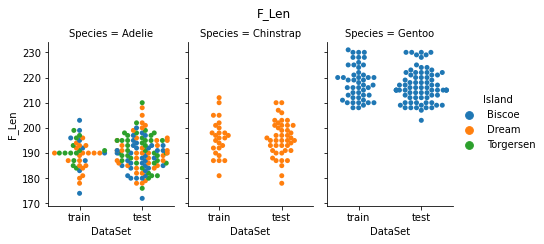

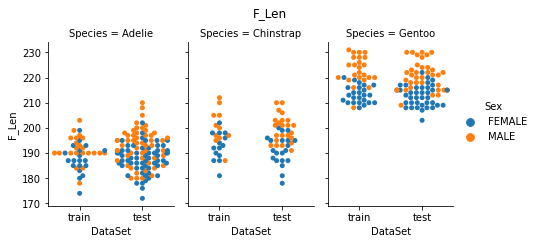

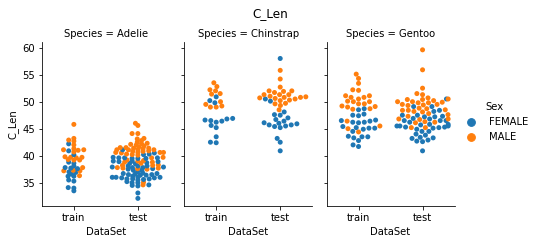

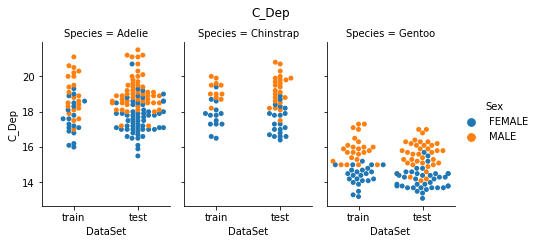

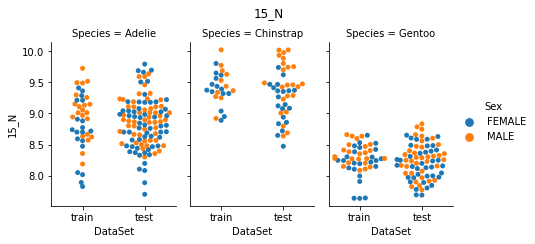

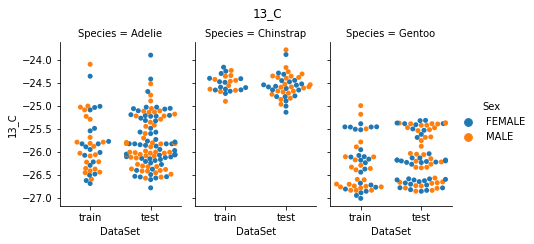

In [33]:
def cat(dataset,y_Data,hue_Data="Sex"):        
    g = sns.catplot(data=dataset,x="DataSet", y=y_Data, col="Species",
                hue=hue_Data, height=3, aspect=0.7, kind="swarm")
    g.fig.suptitle(y_Data,y=1.05)
    display(g)
    
cols = ['Species', 'Island', 'Clutch', 'Sex','C_Len', 'C_Dep', 'F_Len', '15_N', '13_C']
df1 = train_data.loc[:,cols] ; df1['DataSet'] = 'train'
df2 = test_data.loc[:,cols]  ; df2['DataSet'] = 'test'
total_df = pd.concat([df1,df2],ignore_index=True)

cat(total_df,"F_Len", hue_Data = "Island")
cat(total_df,"F_Len")
cat(total_df,"C_Len")
cat(total_df,"C_Dep")
cat(total_df,"15_N")
cat(total_df,"13_C")

## 마치며
자세한 원인은 모르겠으나 전체 Run 할 때마다 최적 parameter와 예측기별 error가 크게 바뀌곤 합니다.  
최고점 (259점) 나온 데이터는 아쉽게도 Randome state를 고정하기 전에 돌렸던 코드입니다.  
과대적합 문제 때문인지, 259점이 나왔을 때 4.5.2에서 점수는 280 후반이었던 걸로 기억합니다.  
4.5.2에서 260점이 되었을 때는 오히려 결과물 제출 점수가 270~280대일 때도 있었습니다.

Dacon 첫 대회 출전에서 운이 좋아 높은 점수를 받은 것 같습니다.  
결과파일 제출 전에 github에 commit하여 동일한 결과물을 뽑을 수 있는 소스를 보존할 수 있도록 하겠습니다.  

작업 중 가장 재미있었던 부분(펭귄 색칠공부) 결과 이미지를 다시 한번 첨부합니다.  
이 pair plot의 점 하나하나가 실제로 살아있는 작은 펭귄들이라 생각히니 참 귀여워 죽겠네요. 

긴 글 읽어주셔서 감사합니다.  


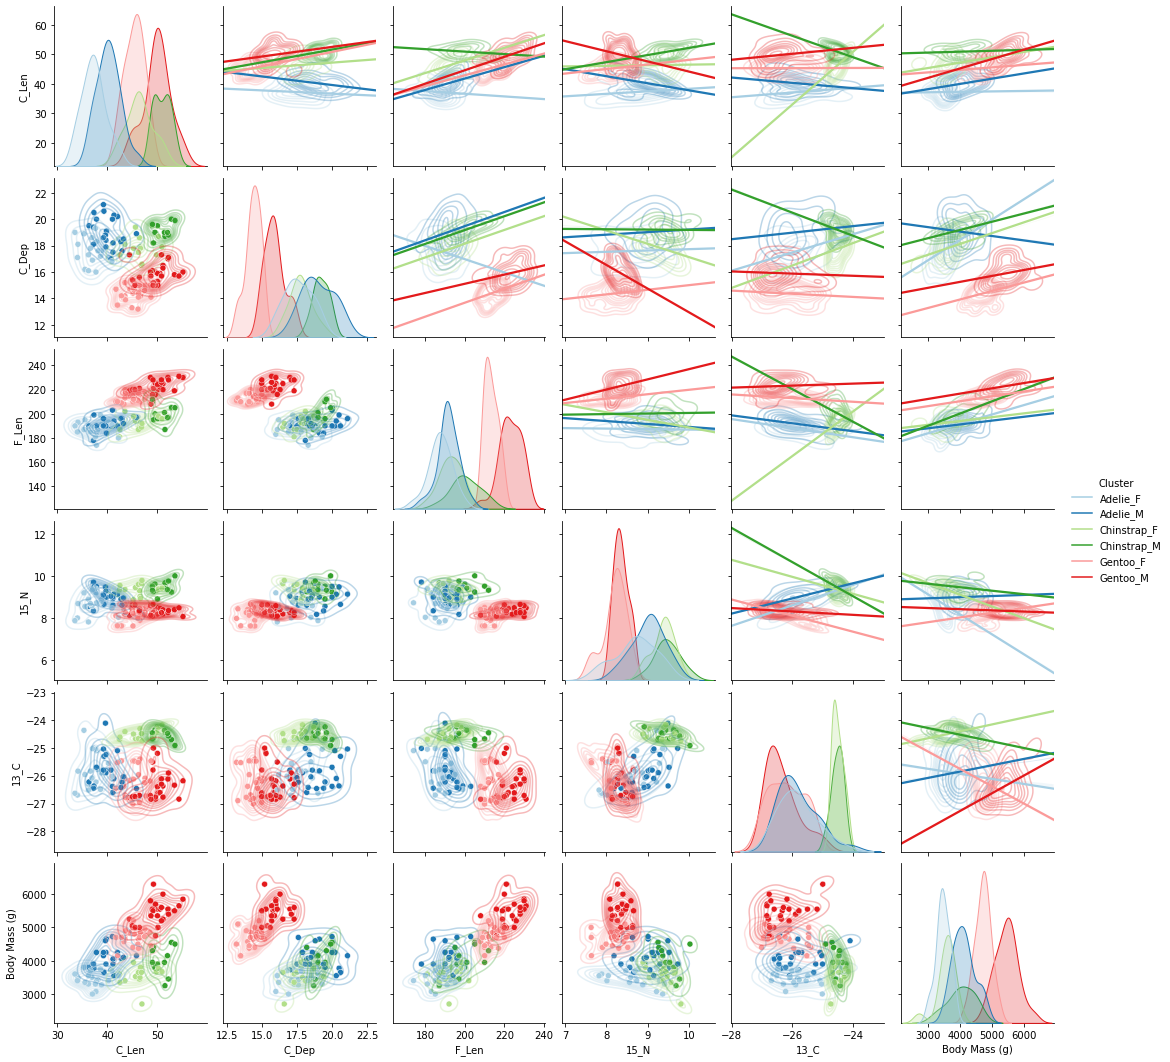

In [34]:
hue_Data = "Cluster"
g = sns.pairplot(train_data[[*cols_numerical,hue_Data]], hue=hue_Data, 
                 kind="kde", plot_kws={"alpha":0.3}, palette="Paired")
g.map_lower(sns.scatterplot)
g.map_upper(sns.regplot, scatter=False, truncate=False, ci=True)    
display(g)